In [26]:
# AlexNet implementation example using TensorFlow library.
# This example is using the MNIST database of handwritten digits (http://yann.lecun.com/exdb/mnist/)
# AlexNet Paper (http://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf)

# Author: Aymeric Damien
# Project: https://github.com/aymericdamien/TensorFlow-Examples/

In [27]:
# # Import MINST data
# import input_data
# mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

In [28]:
%%time
# @aman - the below code used as a replacement of above(not working/commented code)
# mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

# working
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz
Wall time: 846 ms


In [29]:
import tensorflow as tf

In [30]:
# Parameters
learning_rate = 0.001
training_iters = 300000
batch_size = 64
display_step = 100

In [31]:
# @aman -
print(mnist)
print(mnist.train.images)
print(mnist.test.num_examples)


Datasets(train=<tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet object at 0x0000023F6AB7F6A0>, validation=<tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet object at 0x0000023F6974BDA0>, test=<tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet object at 0x0000023F6AB759B0>)
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
10000


(784,)


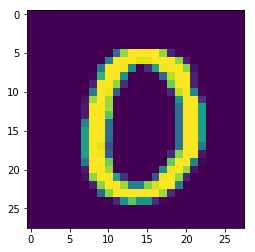

In [32]:
# @aman -

import matplotlib.pyplot as plt
%matplotlib inline
print(mnist.train.images[0].shape)

tmp = mnist.train.images[10].reshape((28,28))

plt.imshow(tmp)

In [33]:
# Network Parameters
n_input = 784 # MNIST data input (img shape: 28*28)
n_classes = 10 # MNIST total classes (0-9 digits)
dropout = 0.8 # Dropout, probability to keep units

In [34]:
# tf Graph input

# @aman- old version
# x = tf.placeholder(tf.types.float32, [None, n_input])
# y = tf.placeholder(tf.types.float32, [None, n_classes])
# keep_prob = tf.placeholder(tf.types.float32) # dropout (keep probability)

x = tf.placeholder(tf.float32, [None, n_input])
y = tf.placeholder(tf.float32, [None, n_classes])
keep_prob = tf.placeholder(tf.float32) # dropout (keep probability)

In [35]:
# Create AlexNet model
def conv2d(name, l_input, w, b):
    return tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(l_input, w, strides=[1, 1, 1, 1], 
                                                  padding='SAME'),b), name=name)

def max_pool(name, l_input, k):
    return tf.nn.max_pool(l_input, ksize=[1, k, k, 1], strides=[1, k, k, 1], 
                          padding='SAME', name=name)

def norm(name, l_input, lsize=4):
    return tf.nn.lrn(l_input, lsize, bias=1.0, alpha=0.001 / 9.0, beta=0.75, name=name)

def alex_net(_X, _weights, _biases, _dropout):
    # Reshape input picture
    _X = tf.reshape(_X, shape=[-1, 28, 28, 1])

    # Convolution Layer
    conv1 = conv2d('conv1', _X, _weights['wc1'], _biases['bc1'])
    # Max Pooling (down-sampling)
    pool1 = max_pool('pool1', conv1, k=2)
    # Apply Normalization
    norm1 = norm('norm1', pool1, lsize=4)
    # Apply Dropout
    norm1 = tf.nn.dropout(norm1, _dropout)

    # Convolution Layer
    conv2 = conv2d('conv2', norm1, _weights['wc2'], _biases['bc2'])
    # Max Pooling (down-sampling)
    pool2 = max_pool('pool2', conv2, k=2)
    # Apply Normalization
    norm2 = norm('norm2', pool2, lsize=4)
    # Apply Dropout
    norm2 = tf.nn.dropout(norm2, _dropout)

    # Convolution Layer
    conv3 = conv2d('conv3', norm2, _weights['wc3'], _biases['bc3'])
    # Max Pooling (down-sampling)
    pool3 = max_pool('pool3', conv3, k=2)
    # Apply Normalization
    norm3 = norm('norm3', pool3, lsize=4)
    # Apply Dropout
    norm3 = tf.nn.dropout(norm3, _dropout)

    # Fully connected layer
    # Reshape conv3 output to fit dense layer input
    dense1 = tf.reshape(norm3, [-1, _weights['wd1'].get_shape().as_list()[0]]) 
    # Relu activation
    dense1 = tf.nn.relu(tf.matmul(dense1, _weights['wd1']) + _biases['bd1'], name='fc1')
    
    # Relu activation
    dense2 = tf.nn.relu(tf.matmul(dense1, _weights['wd2']) + _biases['bd2'], name='fc2') 

    # Output, class prediction
    out = tf.matmul(dense2, _weights['out']) + _biases['out']
    return out

In [36]:
# Store layers weight & bias
weights = {
    'wc1': tf.Variable(tf.random_normal([3, 3, 1, 64])),
    'wc2': tf.Variable(tf.random_normal([3, 3, 64, 128])),
    'wc3': tf.Variable(tf.random_normal([3, 3, 128, 256])),
    'wd1': tf.Variable(tf.random_normal([4*4*256, 1024])),
    'wd2': tf.Variable(tf.random_normal([1024, 1024])),
    'out': tf.Variable(tf.random_normal([1024, 10]))
}
biases = {
    'bc1': tf.Variable(tf.random_normal([64])),
    'bc2': tf.Variable(tf.random_normal([128])),
    'bc3': tf.Variable(tf.random_normal([256])),
    'bd1': tf.Variable(tf.random_normal([1024])),
    'bd2': tf.Variable(tf.random_normal([1024])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

In [37]:
# Construct model
pred = alex_net(x, weights, biases, keep_prob)

In [39]:
# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

In [42]:
# Evaluate model
correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
# @aman- old version
# accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.types.float32))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [44]:
# Initializing the variables
init = tf.initialize_all_variables()

In [46]:
%%time
loss_list = []
iter_list = []
accuracy_list = []

# Launch the graph
with tf.Session() as sess:
    sess.run(init)
    step = 1
    # Keep training until reach max iterations
    while step * batch_size < training_iters:
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        # Fit training using batch data
        sess.run(optimizer, feed_dict={x: batch_xs, y: batch_ys, keep_prob: dropout})
        if step % display_step == 0:
            # Calculate batch accuracy
            acc = sess.run(accuracy, feed_dict={x: batch_xs, y: batch_ys, keep_prob: 1.})
            # Calculate batch loss
            loss = sess.run(cost, feed_dict={x: batch_xs, y: batch_ys, keep_prob: 1.})
            print("Iter " + str(step*batch_size) + ", Minibatch Loss= " \
                  + "{:.6f}".format(loss) + ", Training Accuracy= " + "{:.5f}".format(acc) )
            accuracy_list.append(acc)
            loss_list.append(loss)
            iter_list.append(str(step*batch_size))
        step += 1
    print("Optimization Finished!")
    # Calculate accuracy for 256 mnist test images
    print("Testing Accuracy:", sess.run(accuracy, feed_dict={x: mnist.test.images[:256], 
                                                             y: mnist.test.labels[:256], 
                                                             keep_prob: 1.}) )

Iter 6400, Minibatch Loss= 55149.476562, Training Accuracy= 0.54688
Iter 12800, Minibatch Loss= 13881.750000, Training Accuracy= 0.73438
Iter 19200, Minibatch Loss= 29883.376953, Training Accuracy= 0.70312
Iter 25600, Minibatch Loss= 19046.312500, Training Accuracy= 0.65625
Iter 32000, Minibatch Loss= 13675.036133, Training Accuracy= 0.73438
Iter 38400, Minibatch Loss= 12722.476562, Training Accuracy= 0.78125
Iter 44800, Minibatch Loss= 19732.878906, Training Accuracy= 0.68750
Iter 51200, Minibatch Loss= 9757.503906, Training Accuracy= 0.76562
Iter 57600, Minibatch Loss= 5535.861328, Training Accuracy= 0.85938
Iter 64000, Minibatch Loss= 9417.918945, Training Accuracy= 0.79688
Iter 70400, Minibatch Loss= 10939.797852, Training Accuracy= 0.82812
Iter 76800, Minibatch Loss= 3019.445801, Training Accuracy= 0.87500
Iter 83200, Minibatch Loss= 9605.620117, Training Accuracy= 0.85938
Iter 89600, Minibatch Loss= 1360.823486, Training Accuracy= 0.96875
Iter 96000, Minibatch Loss= 4528.117188, 

In [47]:
import numpy as np
iter_list = [ int(x) for x in iter_list]
loss_list = [ float(x) for x in loss_list]
accuracy_list = [ float(x) for x in accuracy_list]

#np.sum(np.array(iter_list))
np.sum(iter_list)

#np.sum

6918400

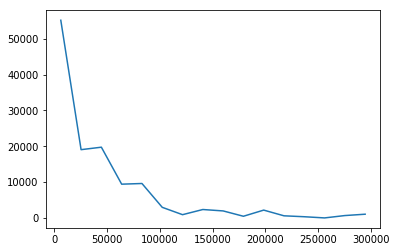

In [48]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(iter_list[::3], loss_list[::3])
plt.show()

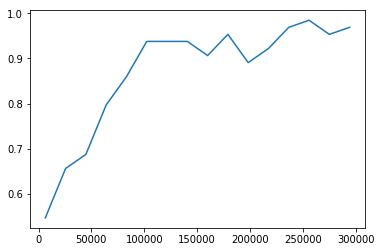

In [49]:
plt.plot(iter_list[::3], accuracy_list[::3])
plt.show()

In [57]:
writer = tf.summary.FileWriter("summary_logs_alexnet", sess.graph)

In [53]:
sess


In [52]:
##############################
### SAVE TRAINED VARIABLES ###
##############################

# Create Saver
saver = tf.train.Saver()
# Save variables to .ckpt file
saver.save(sess, "trained_variables_alexnet.ckpt")

# Don't Close tensorflow session for now during experimentation
# sess.close()

RuntimeError: Attempted to use a closed Session.